# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Описание данных:

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

## Условия задачи:
    
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [4]:
!pip install phik -q

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from tqdm import tqdm


from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, r2_score, mean_absolute_error, root_mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.exceptions import ConvergenceWarning 
from sklearn.tree import export_text
from sklearn.tree import plot_tree

import warnings
from IPython.display import Markdown as md
warnings.simplefilter('ignore', DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:
RANDOM_STATE = 42
TEST_SIZE = .25
DEFAULT_COLOR = '#8174A0'

sns.set_theme()

In [8]:
def check_multicollinearity_vif(df):
    temp = (df
        .drop(columns=['id'], errors='ignore'))

    numeric_cols = (temp
                    .select_dtypes(['float64', 'int', 'int64'])
                    .columns)

    df = pd.DataFrame(temp[numeric_cols], 
                  columns=numeric_cols)

    X = add_constant(df)

    vif = pd.DataFrame(
    {
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }
    )
    return vif

In [9]:
def analyze_residuals(residuals, predictions, model_string=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    
    if model_string is not None:
        axes[0].set_title(f'Гистограмма распределения остатков [{model_string}]')
    else:
        axes[0].set_title(f'Гистограмма распределения остатков')
        
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    
    axes[0].legend()
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    
    axes[1].axhline(y=0, color='red', ls='--')
    
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    if model_string is not None:
        axes[1].set_title(f'Анализ дисперсии [{model_string}]')
    else:
        axes[1].set_title(f'Анализ дисперсии')
        
    plt.show()

In [10]:
def plot_graphics(df, 
                  column_name, 
                  test_df=None, 
                  bins=30, 
                  range_hist=None, 
                  hist_color='#519872', 
                  boxplot_color='#B9D2D2', 
                  col_alias='', 
                  xlabel='', 
                  ylabel='', 
                  figsize=(10, 10)):
    
    if test_df is not None:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax = ax.flatten()
    
        ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Train] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
        ax2.set_title(f'[Train] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        
        ax1 = sns.histplot(data=test_df, x=column_name, ax=ax[2], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Test] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=test_df, x=column_name, ax=ax[3], color=boxplot_color)
        ax2.set_title(f'[Test] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        return 

        
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [11]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report).round(2)


In [12]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

## Первый датасет

In [ ]:
try:
    region_1 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    region_1 = pd.read_csv('path')

In [14]:
region_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [15]:
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


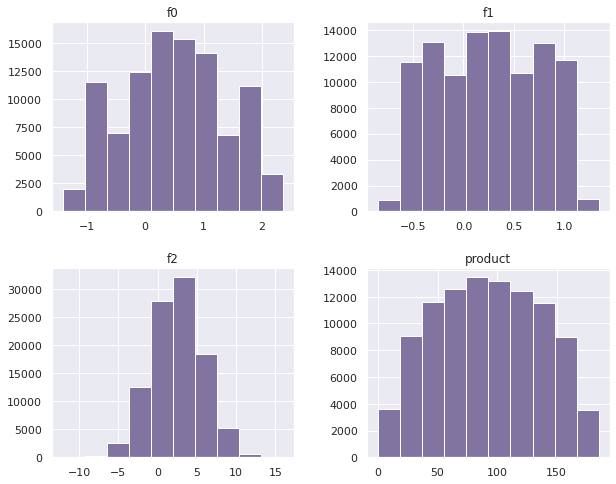

In [16]:
region_1.hist(figsize=(10, 8), color=DEFAULT_COLOR);

- аномально высоких значений не наблюдается

In [17]:
region_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


### Исследование на пропуски

In [18]:
region_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

- пропуски в данных отсутствуют

### Исследование на явные дубликаты

In [19]:
region_1.duplicated().sum()

0

- явных дубликатов в данных нет

### Исследование на неявные дубликаты

In [20]:
region_1.id.duplicated().sum()

10

In [21]:
region_1[region_1.id.isin(region_1[region_1.id.duplicated()].id)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


- В датасете есть дублирующие уникальные идентификаторы, однак им соответствуют разные данные в других столбцах

### Исследование столбца `f0`

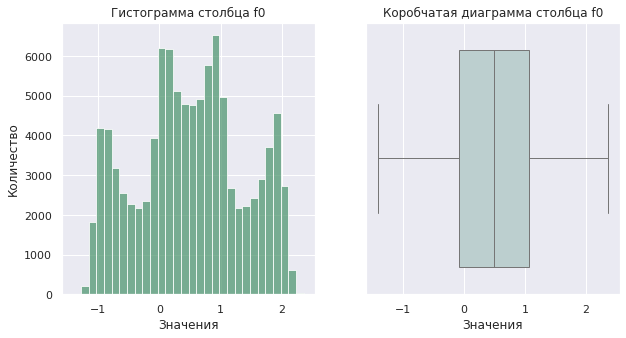

In [22]:
plot_graphics(df=region_1, column_name='f0')

- Наблюдается бимодальность в распределении признака. Два больших пика в области 0 и 1

### Исследование столбца `f1`

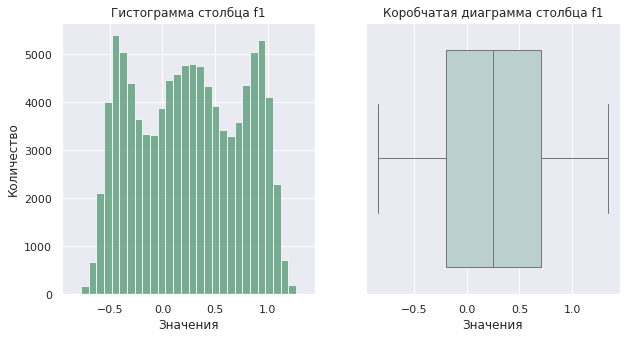

In [23]:
plot_graphics(df=region_1, column_name='f1')

- Наблюдается бимодальность в распределении признака. Два больших пика в области -0.5 и 1

### Исследование столбца `f2`

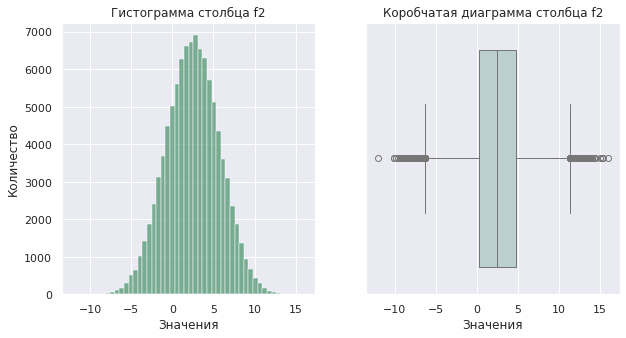

In [24]:
plot_graphics(df=region_1, column_name='f2', bins=50)

- Распределение колоколообразное, по коробчатой диаграмме видны выбросы

In [25]:
outliers_report(df=region_1, column_names=['f2'], strategy='iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,f2,258,0.26,248,0.25


- Аномальных значений по стратегии интерквартильного размаха около половины процента

### Исследование столбца `product`

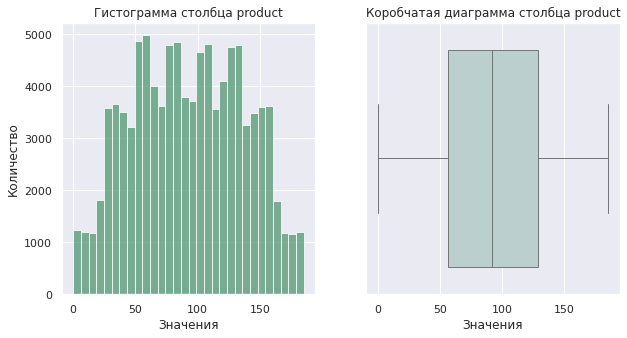

In [26]:
plot_graphics(df=region_1, column_name='product')

### Корреляционный анализ

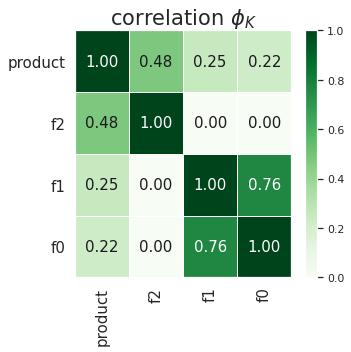

In [27]:
phik_overview = region_1.drop(columns='id').phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(5, 5)) 

warnings.filterwarnings("ignore", category=UserWarning)

### Исследование мультиколлинеарности

In [28]:
check_multicollinearity_vif(region_1)

,Variable,VIF
0,const,6.861281
1,f0,1.248703
2,f1,1.276589
3,f2,1.323671
4,product,1.380659


- Данные не содержат пропусков и явных дубликатов.  
- В датасете есть дублирующие уникальные идентификаторы, однако им соответствуют разные данные в других столбцах
- Аномально высокие значения на гистограммах не выявлены.  
- Признаки `f0` и `f1` имеют бимодальное распределение:  
  - `f0` — два выраженных пика в области 0 и 1.  
  - `f1` — два выраженных пика в области -0.5 и 1.  
- Признак `f2` имеет колоколообразное распределение, при этом около 0.5% значений являются выбросами (по коробчатой диаграмме).  
- Между признаками `f0` и `f1` наблюдается высокая взаимосвязь.  
- Признаков мультиколлинеарности не обнаружено.

# Второй датасет

In [ ]:
try:
    region_2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    region_2 = pd.read_csv('path')

In [30]:
region_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [31]:
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


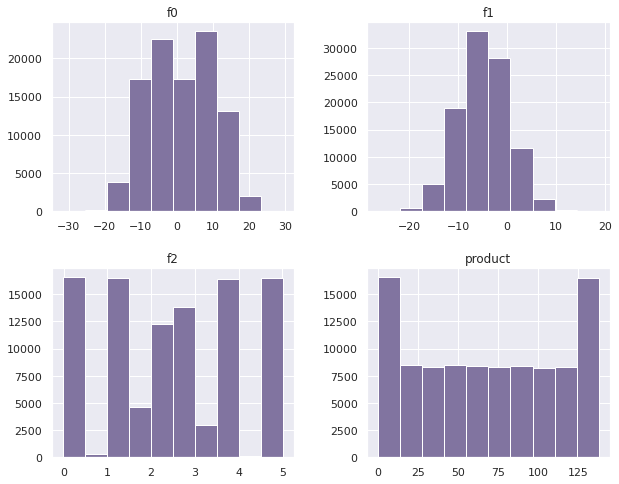

In [32]:
region_2.hist(figsize=(10, 8), color=DEFAULT_COLOR);

In [33]:
region_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


### Исследование на пропуски

In [34]:
region_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

- Пропусков в данных нет

### Исследование на явные дубликаты

In [35]:
region_2.duplicated().sum()

0

- Явных дубликатов нет

### Исследование на неявные дубликаты

In [36]:
region_2.id.duplicated().sum()

4

In [37]:
region_2[region_2.id.isin(region_2[region_2.id.duplicated()].id)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


- C уникальными идентификаторами наблюдается та же проблема, что и первом регионе

### Исследование столбца `f0`

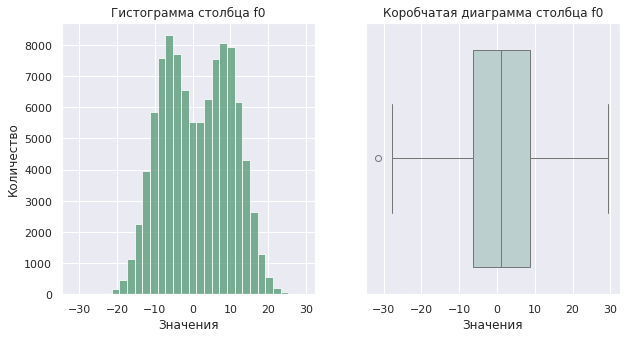

In [38]:
plot_graphics(df=region_2, column_name='f0')

- Наблюдается бимодальность признака `f0`

### Исследование столбца `f1`

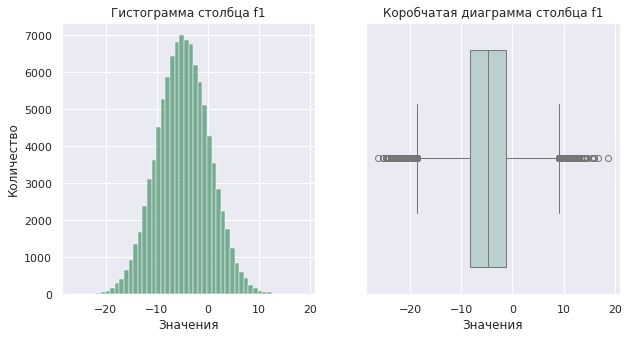

In [39]:
plot_graphics(df=region_2, column_name='f1', bins=50)

- На коробчатой диаграмме видны выбросы

In [40]:
outliers_report(df=region_2, column_names=['f1'], strategy='iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,f1,297,0.3,339,0.34


- Оценка выбросов по стратегии интерквартильного размаха выявила, что общее количество выбросов в этом столбце составляет чуть более половины процента от общего числа элементов столбца

### Исследование столбца `f2`

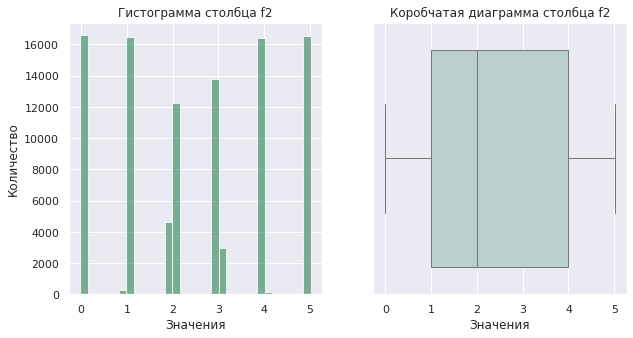

In [41]:
plot_graphics(df=region_2, column_name='f2')

### Исследование столбца `product`

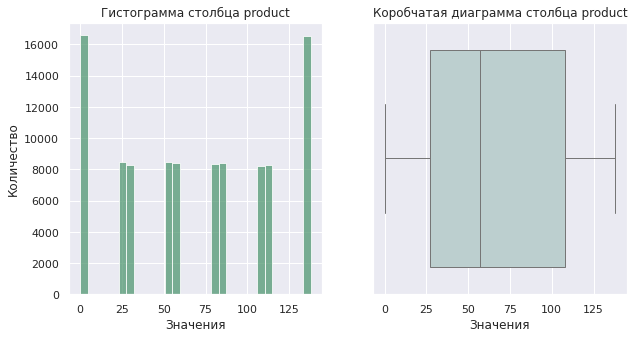

In [42]:
plot_graphics(df=region_2, column_name='product')

### Корреляционный анализ

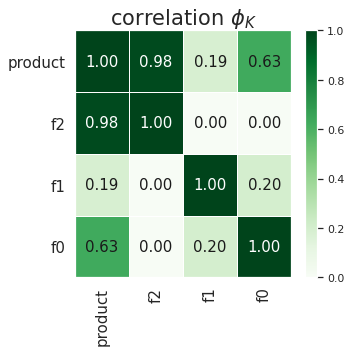

In [43]:
phik_overview = region_2.drop(columns='id').phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(5, 5)) 

warnings.filterwarnings("ignore", category=UserWarning)

- Наблюдается очень большая взаимосвязь между таргетом и признаком `f2`
- Также на целевой признак влияет признак `f0`

### Исследование мультиколлинеарности

In [44]:
check_multicollinearity_vif(region_2)

,Variable,VIF
0,const,7.561536
1,f0,3.163234
2,f1,1.049803
3,f2,2660.141618
4,product,2662.652617


- VIF тест выявил мультиколлинеарность

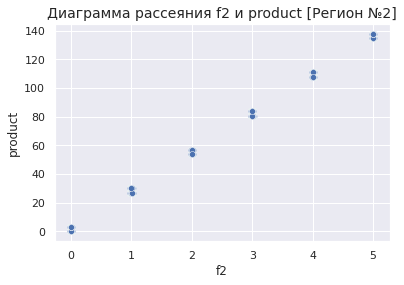

In [45]:
sns.scatterplot(data=region_2, x='f2', y='product').set_title('Диаграмма рассеяния f2 и product [Регион №2]', fontsize=14);

In [46]:
region_2[['f2', 'product']].corr()

,f2,product
f2,1.000000,0.999397
product,0.999397,1.000000


- Анализ данных показал их высокое качество: пропуски и явные дубликаты отсутствуют. 
- Однако проблема с уникальными идентификаторами аналогична ситуации в первом регионе.

- Распределение признаков выявило бимодальность `f0` и наличие выбросов в `f1`, хотя их доля невелика (чуть более 0.5%).

- Между целевым признаком и `f2` наблюдается очень высокая взаимосвязь, что подтверждается диаграммой рассеяния и коэффициентом корреляции Пирсона, практически равным 1. Это может указывать на возможную зависимость или утечку данных.

- Также признак `f0` оказывает влияние на целевой признак. При этом тест VIF выявил проблему мультиколлинеарности, что может потребовать пересмотра модели или исключения избыточных переменных. Однако, в силу условий задачи, признаки исключать нельзя, все они являются важными для принятия решения

# Третий датасет

In [ ]:
try:
    region_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    region_3 = pd.read_csv('path')

In [48]:
region_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [49]:
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


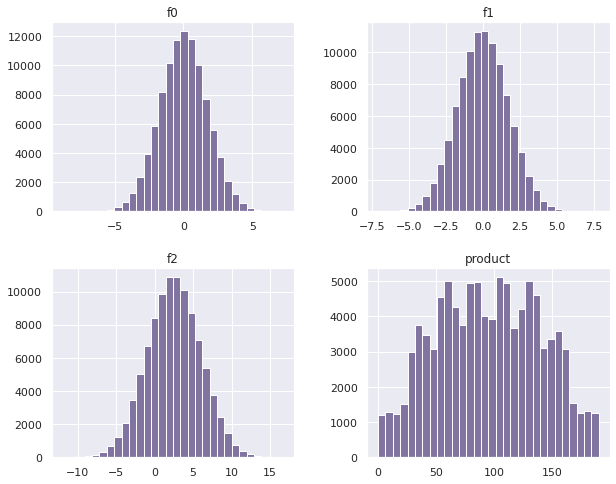

In [50]:
region_3.hist(figsize=(10, 8), color=DEFAULT_COLOR, bins=30);

- Первичный анализ гистограмм выявил колоколообразность распределений всех столбцов

### Исследование на пропуски

In [51]:
region_3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

### Исследование на явные дубликаты

In [52]:
region_3.duplicated().sum()

0

### Исследование на неявные дубликаты

In [53]:
region_3.id.duplicated().sum()

4

In [54]:
region_3[region_3.id.isin(region_3[region_3.id.duplicated()].id)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


### Исследование столбца `f0`

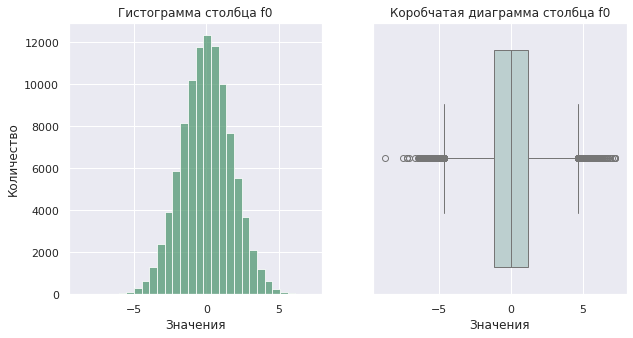

In [55]:
plot_graphics(df=region_3, column_name='f0')

In [56]:
outliers_report(df=region_3, column_names=['f0'], strategy='iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,f0,348,0.35,385,0.38


- Выбросов в столбце `f0` менее одного процента

### Исследование столбца `f1`

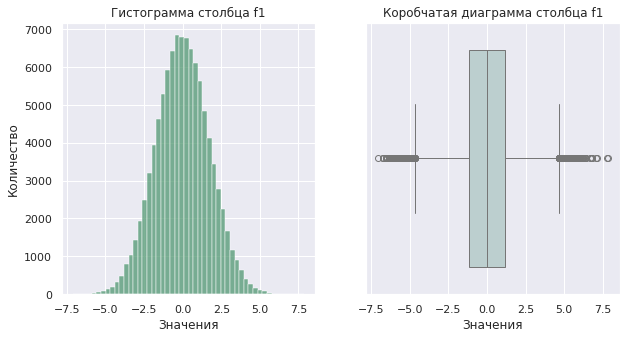

In [57]:
plot_graphics(df=region_3, column_name='f1', bins=50)

In [58]:
outliers_report(df=region_3, column_names=['f1'], strategy='iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,f1,335,0.34,349,0.35


- Выбросов в столбце `f1` менее одного процента

### Исследование столбца `f2`

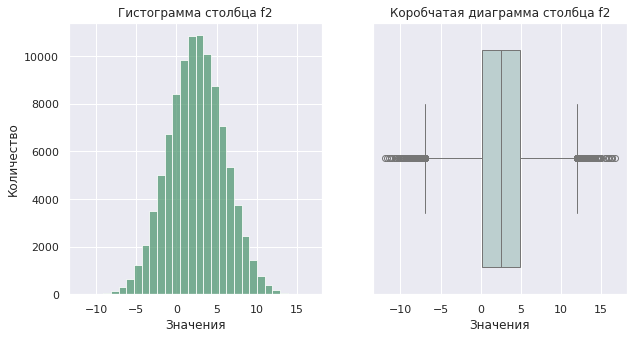

In [59]:
plot_graphics(df=region_3, column_name='f2')

In [60]:
outliers_report(df=region_3, column_names=['f2'], strategy='iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,f2,301,0.3,283,0.28


- Выбросов в столбце `f2` чуть более половины процента

### Исследование столбца `product`

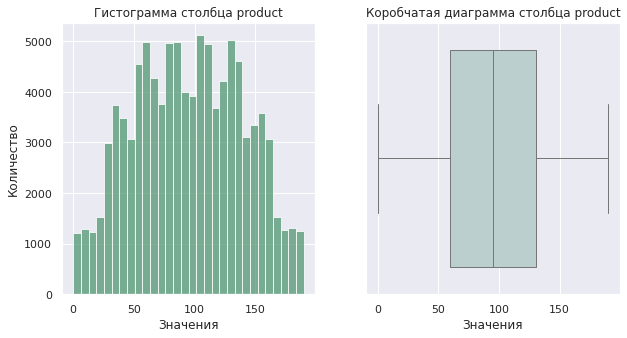

In [61]:
plot_graphics(df=region_3, column_name='product')

### Корреляционный анализ

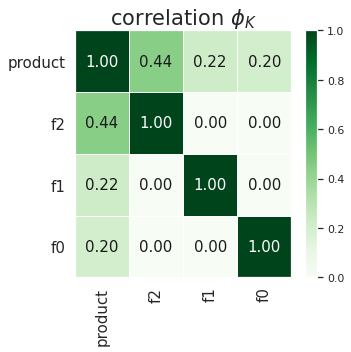

In [62]:
phik_overview = region_3.drop(columns='id').phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(5, 5)) 

warnings.filterwarnings("ignore", category=UserWarning)

- Корреляционный анализ показывает среднюю взаимосвязь между таргетом и `f2`

### Исследование мультиколлинеарности

In [63]:
check_multicollinearity_vif(region_3)

,Variable,VIF
0,const,5.571816
1,f0,1.000004
2,f1,1.000003
3,f2,1.248132
4,product,1.248137


- Первичный анализ данных показал, что распределения всех признаков имеют колоколообразную форму. 
- Пропуски и явные дубликаты отсутствуют, однако проблема с уникальными идентификаторами сохраняется, как и в других датасетах.  

- Выбросы присутствуют в небольшом количестве: менее 1% в `f0` и `f1`, а в `f2` — чуть более 0.5% от общего числа наблюдений.  

- Корреляционный анализ выявил среднюю взаимосвязь между целевым признаком и `f2` (коэффициент 0.44), что указывает на возможное влияние, но без явной зависимости.  

- Проблема мультиколлинеарности отсутствует, что подтверждено тестом VIF. Данные пригодны для дальнейшего моделирования без необходимости корректировки из-за избыточных взаимосвязей между признаками.

## Обучение модели

In [64]:
def train_and_predict(region_df):
    X_train, X_test, y_train, y_test = train_test_split(region_df.drop(columns=['id', 'product']), 
                                                    region_df['product'], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    return X_test_scaled, y_test, predictions, model

In [65]:
X_test_1, y_test_1, preds_1, m1 = train_and_predict(region_1)
X_test_2, y_test_2, preds_2, m2 = train_and_predict(region_2)
X_test_3, y_test_3, preds_3, m3 = train_and_predict(region_3)


training_report = pd.DataFrame([
    {
        'Средний предсказанный запас': preds.mean().round(2),
        'RMSE (validation)': round(root_mean_squared_error(y_test, preds), 2)
    }
    for (y_test, preds) in [(y_test_1, preds_1), (y_test_2, preds_2), (y_test_3, preds_3)]
], columns=['Средний предсказанный запас', 'RMSE (validation)'], index=['Регион №1', 'Регион №2', 'Регион №3'])


training_report

,Средний предсказанный запас,RMSE (validation)
Регион №1,92.40,37.76
Регион №2,68.71,0.89
Регион №3,94.77,40.15


Анализ предсказанных запасов нефти и точности моделей показывает, что наибольший средний запас наблюдается в Регионе №3 (94.77), за ним следует Регион №1 (92.40), а наименьший — в Регионе №2 (68.71). 

Однако при этом в Регионе №2 модель демонстрирует наивысшую точность предсказаний с минимальной ошибкой (RMSE 0.89), тогда как в Регионах №1 и №3 ошибки значительно выше (37.76 и 40.15 соответственно). 

Высокие значения RMSE в первом и третьем регионах указывают на большую неопределенность в прогнозах, что может повлиять на принятие решений. 

- Регион №3 имеет наибольший средний запас, высокая ошибка предсказания снижает уверенность в оценке. 
- Регион №1 также демонстрирует высокий средний запас, но с большой погрешностью. 
- Регион №2, несмотря на самый низкий средний запас, отличается наиболее стабильными и точными предсказаниями. 

## Анализ безубыточности

$$ \text{Доход} = N \cdot \text{Цена за баррель} - \text{Расходы на установку} \Rightarrow N = \frac{\text{Доход} + \text{Расходы на установку}}{\text{Цена за баррель}}$$

Исследуем вопрос безубыточности, то есть когда $\text{Доход} \geqslant 0$. 

Пограничное значение при условии безубыточности: $\text{Доход} = 0$, поэтому $$N_{\text{мин}} = \frac{\text{Расходы на установку}}{\text{Цена за баррель}}$$

In [66]:
SETTING_COST = 1e10
PRICE_PER_BARREL = 450
N_BEST = 200

In [67]:
n_min_1000 = SETTING_COST / (PRICE_PER_BARREL * 1000)
round(n_min_1000 / N_BEST, 2)

111.11

Для того, чтобы перекрыть расходы на установку необходимо, чтобы месторождение имело средний запас не менее 111.11 тыс. баррелей. Сопоставляя с предсказаниями, делаем вывод, что в среднем все месторождения во всех регионах в среднем имеют меньший запас. Поэтому необходим отбор 200 наилучших скважин, чтобы окупить расходны на установку

## Анализ остатков моделей

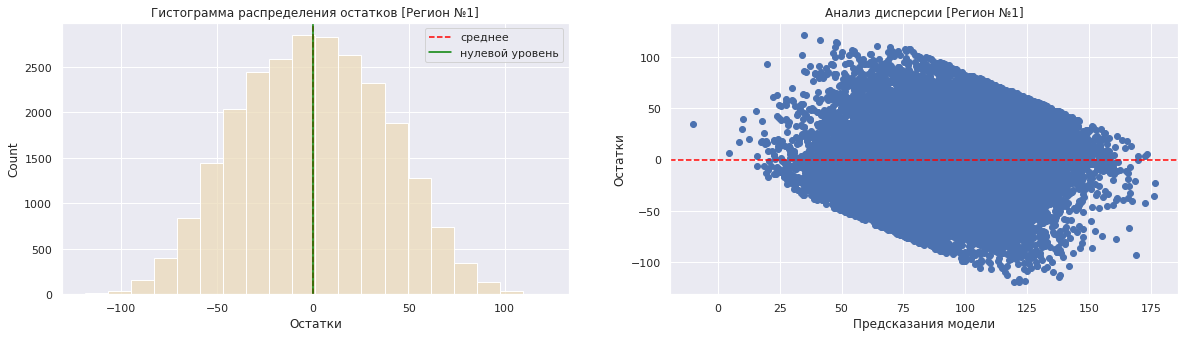

In [68]:
analyze_residuals(y_test_1 - preds_1, preds_1, 'Регион №1')

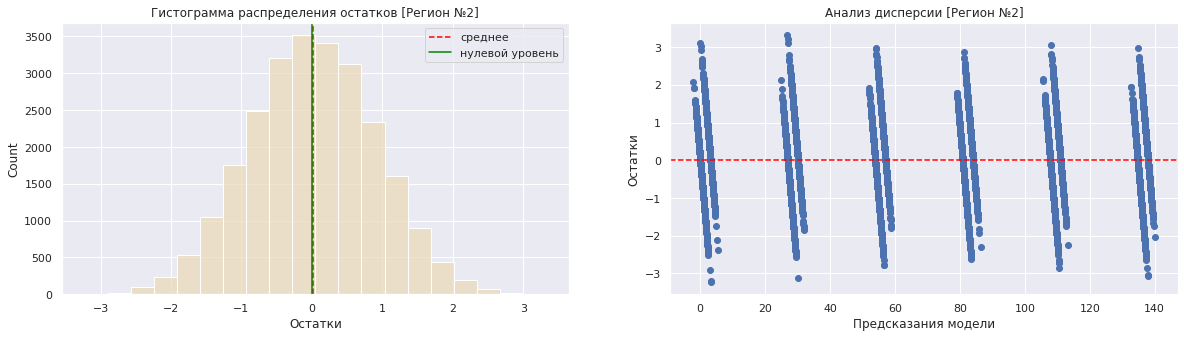

In [69]:
analyze_residuals(y_test_2 - preds_2, preds_2, 'Регион №2')

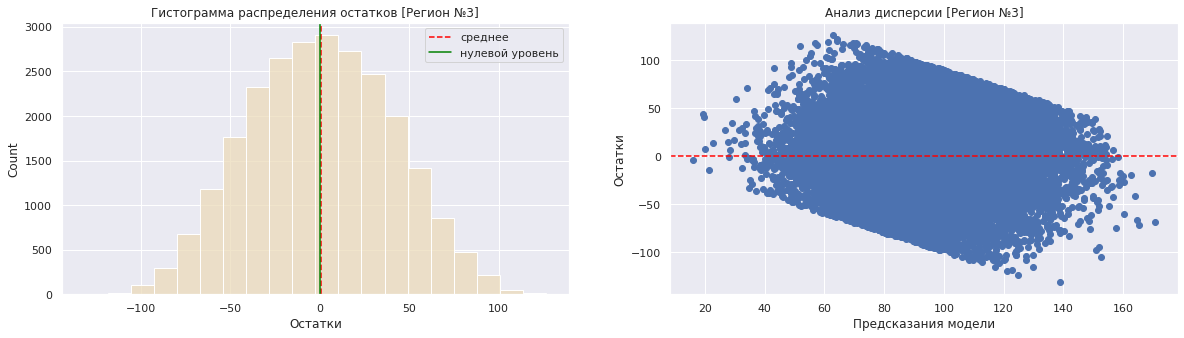

In [70]:
analyze_residuals(y_test_3 - preds_3, preds_3, 'Регион №3')

- Распределения остатков достаточно симметричные, средние значения практически совпадают с нулевым уровнем
- Дисперсия остатков для первого и третьего регионов распределена неравномерно. На границах диапазона предсказаний наблюдаются явные тенденции (слева - модель занижает предсказания, справа - завышает). 
- Модель для второго региона интереснее. Дисперсия остатков имеет дискретную структуру. Остатки принимают значения из ограниченного диапазона

## Исследование прибыли и рисков

$$ \text{Прибыль} = 450000 \text{ тыс.руб.} * \sum_{i=1}^{\text{top200}}\text{product} - \text{бюджет на возведение},$$
где top200 получены в ходе оценки регрессией

Вероятность рисков будем оценивать с помощью выборочной функции bootstrap-распределения. 

$$ \text{Риск убытков } = \frac{\text{Количество отрицательных элементов в bootstrap-распределении}}{\text{Общее число элементов в bootstrap-распределении}} $$

In [72]:
def income(y_pred, target, count):
    
    y_pred_sorted_idx = y_pred.sort_values(ascending=False).index
    selected = target[y_pred_sorted_idx][:count] # отбор делаем уже на реальных данных для избегания дублирования
    
    return selected.sum() * PRICE_PER_BARREL * 1000 - SETTING_COST

In [73]:
def bootstrap(test, pred):
    
    scores = []
    
    for i in range(1000):
        target_subsample = test.sample(n=500, replace=True, random_state=state)
        pred_series = pd.Series(pred, index=test.index)
        scores.append(income(pred_series[target_subsample.index],target_subsample, N_BEST))
        
    return pd.Series(scores) / 1e6

In [74]:
state = np.random.RandomState(RANDOM_STATE)

In [75]:
def bootstrap_confidence_interval(test, pred, reg):
    
    scores = bootstrap(test, pred)
    
    ax = scores.hist(bins=30, color='blue', alpha=.3, figsize=(20, 5), density=1)
    ax = scores.plot(kind='kde')
    
    ax.vlines(x=scores.mean(), 
              ymin=0, 
              ymax=.0015, 
              color='red', 
              ls='--', 
              label=f'Ср. доход: {(scores.mean()).round(2)} млн. руб.')
    
    ax.vlines(x=scores.median(), 
              ymin=0, 
              ymax=.0015, 
              color='blue', 
              ls='--', 
              label=f'Медиана: {(scores.median()).round(2)} млн. руб.')
    
    ax.axvspan(xmin=scores.quantile(.025), 
               xmax=scores.quantile(.975), 
               alpha=.1, 
               ymax=5, 
               color='green', 
               label=f'Дов. интервал: [{scores.quantile(.025).round(2)}, {scores.quantile(.975).round(2)}]')
    
    ax.axvspan(xmin=scores.quantile(.5) - scores.std(), 
               xmax=scores.quantile(.5) + scores.std(), 
               alpha=.15, 
               ymax=5, 
               color=DEFAULT_COLOR, 
               label=f'median $\pm \sigma$: [{(scores.quantile(.5) - scores.std()).round(2)}, {(scores.quantile(.5) + scores.std()).round(2)}]')
    
    ax.axvspan(xmin=scores.min(), 
               xmax=0, 
               alpha=.08, 
               ymax=5, 
               color='red', 
               label=f'Убыточная область. Риск убытков: {((scores < 0).mean() * 100).round(2)}%')
    
    ax.set_title(f'[{reg}] Бутстрап распределение дохода с нанесением среднего значения и 95% доверительного интервала' )
    ax.set_xlabel('Доход, млн. руб.')
    ax.legend(fontsize=14);
    
    return scores, ((scores < 0).mean() * 100).round(2)

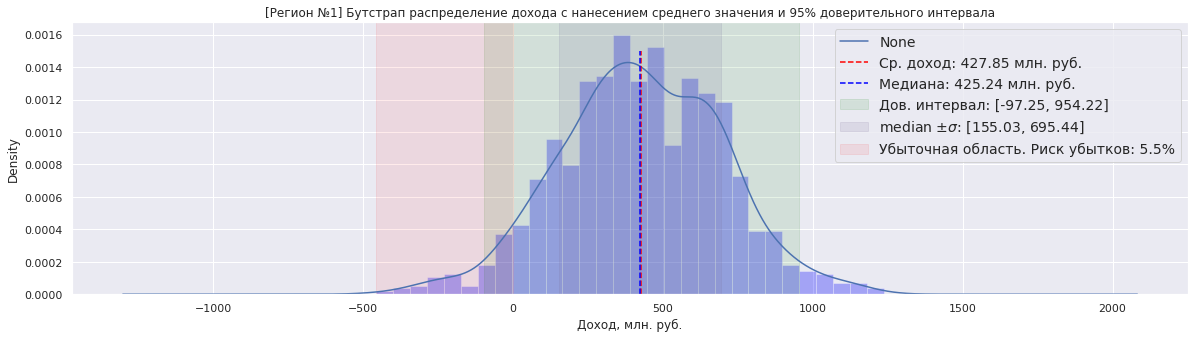

In [76]:
scores_1, risk1 = bootstrap_confidence_interval(y_test_1, preds_1, 'Регион №1')

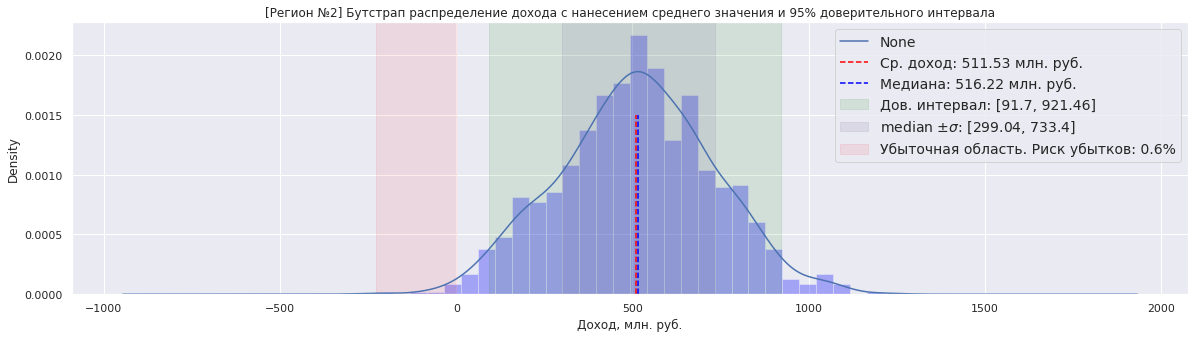

In [77]:
scores_2, risk2 = bootstrap_confidence_interval(y_test_2, preds_2, 'Регион №2')

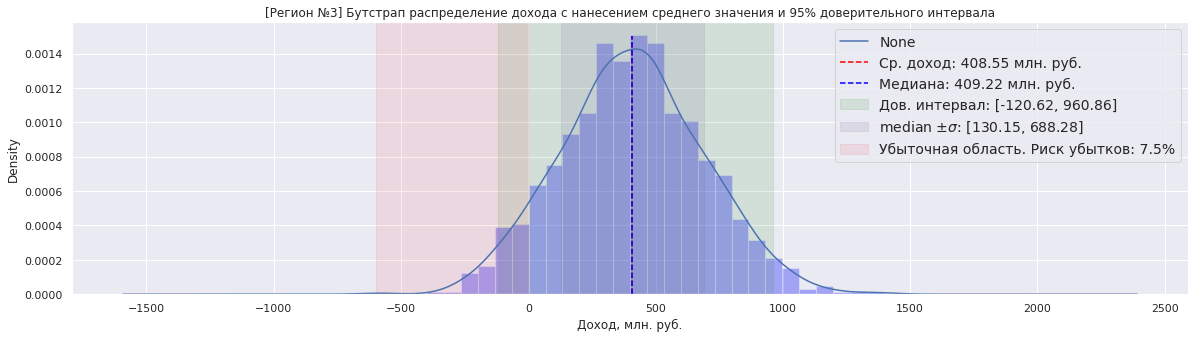

In [78]:
scores_3, risk3 = bootstrap_confidence_interval(y_test_3, preds_3, 'Регион №3')

In [79]:
satisfied_regions = list(filter(lambda x: x[1] < 2.5,
[('Регион №1', risk1, scores_1),
     ('Регион №2', risk2, scores_2),
     ('Регион №3', risk3, scores_3)]))

best_region = sorted(satisfied_regions, key=lambda x: x[2].mean(), reverse=True)[0]

report = ''

for r in satisfied_regions:
    report += f'    - {r[0]} с риском убытка {r[1]}% и 95% доверительным интервалом прибыли (млн. руб.) [{r[2].quantile(.025).round(2)}, {r[2].quantile(.975).round(2)}]. Последний получен с помощью bootstrap техники.\n'

## Вывод

В ходе выполнения проекта были исследованы три региона с месторождениями нефти. Для каждого региона рассчитаны средние значения прибыли, оценены риски убыточности, а также определены доверительные интервалы с использованием метода Bootstrap.  

На первом этапе проведен разведочный анализ данных, включая исследование корреляции признаков и проверку на мультиколлинеарность. Во втором датасете выявлена сильная (почти 100%) корреляция одного из предикторов с целевой переменной**, а также признаки мультиколлинеарности, подтвержденные коэффициентом VIF.  

Далее для каждого региона была обучена модель линейной регрессии, после чего проведен анализ остатков. Несмотря на их небольшое смещение относительно нуля, во всех трех моделях наблюдается неравномерность дисперсии остатков.  

Анализ экономических условий показал, что для покрытия затрат на установку средний запас нефти в месторождении должен быть не менее 111,11 тыс. баррелей. Однако предсказания модели показывают, что в среднем запасы во всех регионах ниже этого порога. Поэтому для обеспечения прибыльности принимается решение отбирать 200 наиболее перспективных месторождений с наибольшими предсказанными запасами. Количество месторождений в каждом регионе довольно велико, поэтому согласно ТЗ при разведке региона выбирается 500 месторождений, из которых в свою очередь выбирают 200 наиболее перспективных.

На завершающем этапе были рассчитаны средние значения прибыли и риска убыточности для каждого региона, что позволило определить наиболее перспективную область для инвестиций. Результаты следующие:

In [80]:
print(f'''
Согласно техническому заданию регион считается подходящим, если риск убыли менее 2.5%. Этому требованию удовлетворяют регионы:

{report}

Наиболее выгодным является {best_region[0]} со средней прибылью {best_region[2].mean().round(2)} млн. руб.
''')


Согласно техническому заданию регион считается подходящим, если риск убыли менее 2.5%. Этому требованию удовлетворяют регионы:

    - Регион №2 с риском убытка 0.6% и 95% доверительным интервалом прибыли (млн. руб.) [91.7, 921.46]. Последний получен с помощью bootstrap техники.


Наиболее выгодным является Регион №2 со средней прибылью 511.53 млн. руб.

